# # Word2Vec(CBow)

## Step 1: Load and Tokenize WikiText-2
1. Load WikiText-2 using Hugging Face's datasets library.
2. Preprocess the text by tokenizing it into words.
3. Build the vocabulary and map words to indices.

In [1]:
from datasets import load_dataset
from collections import Counter
import torch
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# Step 1.1: Load the WikiText-2 dataset
def load_wikitext2():
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")  # Use the training split
    return dataset["text"]

text_data = load_wikitext2()
text_data[:5]

['',
 ' = Valkyria Chronicles III = \n',
 '',
 ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more f

In [3]:
# Step 1.2: Tokenize the text
def tokenize_text(text):
    tokenized_corpus = [sentence.split() for sentence in text if sentence.strip()]  # Split by words, remove empty lines
    return tokenized_corpus

tokenized_corpus = tokenize_text(text_data)
tokenized_corpus[0]

['=', 'Valkyria', 'Chronicles', 'III', '=']

In [4]:
import nltk
from nltk.corpus import stopwords
import string
import re

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Define a function to clean the tokenized text
def clean_tokenized_text(tokenized_corpus):
    stop_words = set(stopwords.words('english'))  # Load English stopwords
    cleaned_corpus = []
    
    for sentence in tokenized_corpus:
        # Remove punctuation, numbers, and symbols; convert to lowercase
        cleaned_sentence = [
            word.lower()
            for word in sentence
            if word.lower() not in stop_words  # Remove stopwords
            and not re.search(r'\d', word)  # Remove words containing digits
            and word.isalpha()  # Keep only alphabetic words
        ]
        cleaned_corpus.append(cleaned_sentence)
    
    return cleaned_corpus

cleaned_corpus = clean_tokenized_text(tokenized_corpus)

# View the first cleaned sentence
print(cleaned_corpus[0])

[nltk_data] Downloading package stopwords to /home/deep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['valkyria', 'chronicles', 'iii']


In [5]:
# Step 1.3: Build vocabulary
def build_vocab(tokenized_corpus):
    word_counts = Counter(word for sentence in tokenized_corpus for word in sentence)
    vocabulary = {word: idx for idx, (word, _) in enumerate(word_counts.items())}
    return vocabulary, word_counts

vocabulary, word_counts = build_vocab(tokenized_corpus)
len(vocabulary), word_counts.most_common(10)

(76616,
 [('the', 113161),
  (',', 99913),
  ('.', 73388),
  ('of', 56889),
  ('and', 50603),
  ('in', 39453),
  ('to', 39190),
  ('a', 34237),
  ('=', 29570),
  ('"', 28309)])

# 2. Cbow
## Step 1: Generate (context word, center word) pairs
For the Cbow model:
- Select a center word from the corpus.
- Define a window size (number of words on either side of the center word to consider as context).
- For each center word, generate pairs of (center word, context word) for all words within the window.

In [6]:
# Step 1.1:Generate CBOW pairs
def generate_cbow_pairs(tokenized_corpus, vocab, window_size=2):
    pairs = []
    for sentence in tokenized_corpus:
        indices = [vocab[word] for word in sentence if word in vocab]
        for center_idx in range(len(indices)):
            # Define the context window range
            start = max(0, center_idx - window_size)
            end = min(len(indices), center_idx + window_size + 1)

            # Exclude the center word
            context = [indices[i] for i in range(start, end) if i != center_idx]
            if len(context) == 2 * window_size:  # Ensure full context is available
                pairs.append((context, indices[center_idx]))
    return pairs

# Generate CBOW pairs
window_size = 2
cbow_pairs = generate_cbow_pairs(tokenized_corpus, vocabulary)

print("Number of CBOW Pairs:", len(cbow_pairs))
print("Sample Pairs (context indices, center index):", cbow_pairs[:5])

Number of CBOW Pairs: 1957683
Sample Pairs (context indices, center index): [([0, 1, 3, 0], 2), ([4, 5, 6, 7], 1), ([5, 1, 7, 8], 6), ([1, 6, 8, 2], 7), ([6, 7, 2, 9], 8)]


## Step 2: Create a PyTorch Dataset
The Dataset class will
1. Store the generated (center, context) pairs.
2. Provide an interface to retrieve pairs one batch at a time using DataLoader.

In [7]:
from torch.utils.data import Dataset, DataLoader

batch_size = 2048
# Step 1: Define the CBOWDataset
class CBOWDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        context, center = self.pairs[idx]
        return torch.tensor(context, dtype=torch.long).to(device), torch.tensor(center, dtype=torch.long).to(device)


In [ ]:
# Step 2: Initialize the Dataset and DataLoader
def create_dataloader(cbow_pairs, batch_size=128, shuffle=True):
    dataset = CBOWDataset(cbow_pairs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# Create the DataLoader
batch_size = 2048
cbow_dataloader = create_dataloader(cbow_pairs, batch_size=batch_size)

for i, (centers, contexts) in enumerate(cbow_dataloader):
    print(f"Batch {i+1}:")
    print("Centers:", centers[:5])  # Display first 5 center words in the batch
    print("Contexts:", contexts[:5])  # Display first 5 context words in the batch
    break

## Step 3: Define the CBOW Model
The CBOW model has the following components:
- Embedding Layer: Maps the context words (input) to dense vectors.
- Averaging: Averages the embeddings of the context words.
- Output Layer: Maps the averaged vector to probabilities over the vocabulary using a linear layer.
- Softmax: Computes the probability distribution over the vocabulary for predicting the center word.


In [8]:
import torch.nn as nn

class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Output layer
        self.fc = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context_words):
        # Get embeddings for context words
        embeds = self.embedding(context_words)  # Shape: (batch_size, context_size, embedding_dim)
        avg_embeds = embeds.mean(dim=1)  # Average across context words: Shape: (batch_size, embedding_dim)
        output = self.fc(avg_embeds)  # Shape: (batch_size, vocab_size)
        return output

## Step 4: Training Logic
The training loop involves the following steps:

- Negative Sampling: Sample negative examples for each center word in a batch.
- Forward and Backward Pass: Compute the loss, backpropagate, and calculate gradients.
- Weight Update: Update model weights using the optimizer.
- Learning Rate Decay: Apply a 10% decay to the learning rate after each epoch.

In [9]:
import torch.optim as optim
from tqdm import tqdm

# Hyperparameters
embedding_dim = 300
num_epochs = 10
learning_rate = 0.002
batch_size = 1024
vocab_size = len(vocabulary)

# Initialize the model, loss, and optimizer
cbow_model = CBOWModel(vocab_size, embedding_dim).to(device)
criterion = nn.CrossEntropyLoss().to(device)  # Predicting a single class (center word)
optimizer = optim.Adam(cbow_model.parameters(), lr=learning_rate)

# Learning rate scheduler for 10% decay after each epoch
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer, 
    lr_lambda=lambda epoch: 0.9 ** epoch  # Decay by 10% every epoch
)
all_loss = []

In [10]:
# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for contexts, centers in tqdm(cbow_dataloader):

        centers = centers.to(device)
        contexts = contexts.to(device)
        
        # Forward pass
        outputs = cbow_model(contexts)  # Shape: (batch_size, vocab_size)
        loss = criterion(outputs, centers)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    current_lr = scheduler.get_last_lr()[0]
    all_loss.append(total_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")

100%|█████████████████████████████████████████| 956/956 [11:31<00:00,  1.38it/s]


Epoch 1/10, Loss: 6606.8595


100%|█████████████████████████████████████████| 956/956 [11:37<00:00,  1.37it/s]


Epoch 2/10, Loss: 5290.2520


100%|█████████████████████████████████████████| 956/956 [11:32<00:00,  1.38it/s]


Epoch 3/10, Loss: 4710.6443


100%|█████████████████████████████████████████| 956/956 [11:27<00:00,  1.39it/s]


Epoch 4/10, Loss: 4305.8419


100%|█████████████████████████████████████████| 956/956 [06:28<00:00,  2.46it/s]


Epoch 5/10, Loss: 4015.9974


100%|█████████████████████████████████████████| 956/956 [02:56<00:00,  5.42it/s]


Epoch 6/10, Loss: 3803.4520


100%|█████████████████████████████████████████| 956/956 [02:51<00:00,  5.56it/s]


Epoch 7/10, Loss: 3638.5531


100%|█████████████████████████████████████████| 956/956 [02:52<00:00,  5.54it/s]


Epoch 8/10, Loss: 3505.8430


100%|█████████████████████████████████████████| 956/956 [02:55<00:00,  5.46it/s]


Epoch 9/10, Loss: 3396.7083


100%|█████████████████████████████████████████| 956/956 [03:04<00:00,  5.19it/s]

Epoch 10/10, Loss: 3305.3925


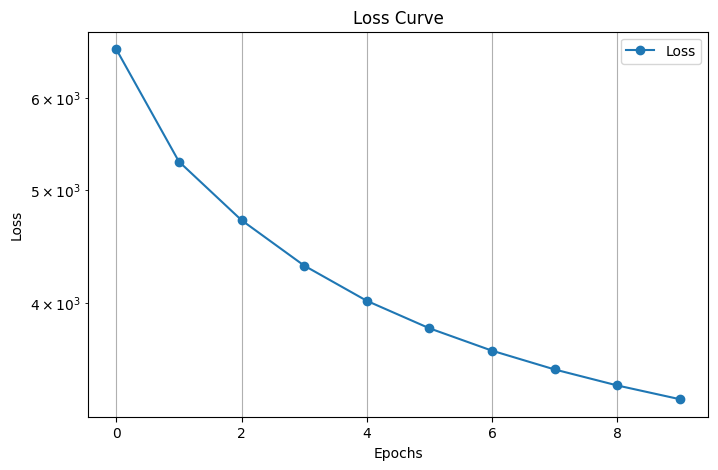

In [11]:
import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(all_loss, marker='o', linestyle='-', label='Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Use a logarithmic scale for better visualization of large values
plt.grid(True)
plt.legend()
plt.show()

## Step 5: Save and Extract Word Embeddings

In [12]:
import os
import csv

# Step 1: Save embeddings to a CSV file
def save_embeddings_to_csv(model, vocabulary, output_file="word_embeddings_cbow.csv"):
    # Extract input embeddings from the model
    embeddings = model.embedding.weight.data.cpu().numpy()
    
    # Open the CSV file for writing
    with open(output_file, mode="w", newline="") as f:
        writer = csv.writer(f)
        
        # Write the header (optional)
        writer.writerow(["Word"] + [f"Dim{i}" for i in range(embeddings.shape[1])])
        
        # Write each word and its embedding
        for word, idx in vocabulary.items():
            vector = embeddings[idx]
            writer.writerow([word] + vector.tolist())
    
    print(f"Embeddings saved to {output_file}")

# Save the embeddings to a CSV file
save_embeddings_to_csv(cbow_model, vocabulary)

Embeddings saved to word_embeddings_cbow.csv


## Step 6: Visualize Word Embeddings with t-SNE

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Step 8.1: Extract embeddings
def extract_embeddings(model, vocabulary):
    embeddings = model.embedding.weight.data.cpu().numpy()  # Input embeddings
    words = list(vocabulary.keys())
    return embeddings, words

# Extract and visualize
embeddings, words = extract_embeddings(cbow_model, vocabulary)

/home/deep/.conda/envs/dl_papers/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25126 (\N{CJK UNIFIED IDEOGRAPH-6226}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/deep/.conda/envs/dl_papers/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22580 (\N{CJK UNIFIED IDEOGRAPH-5834}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/deep/.conda/envs/dl_papers/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/deep/.conda/envs/dl_papers/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12532 (\N{KATAKANA LETTER VU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/deep/.conda/envs/dl_papers/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarnin

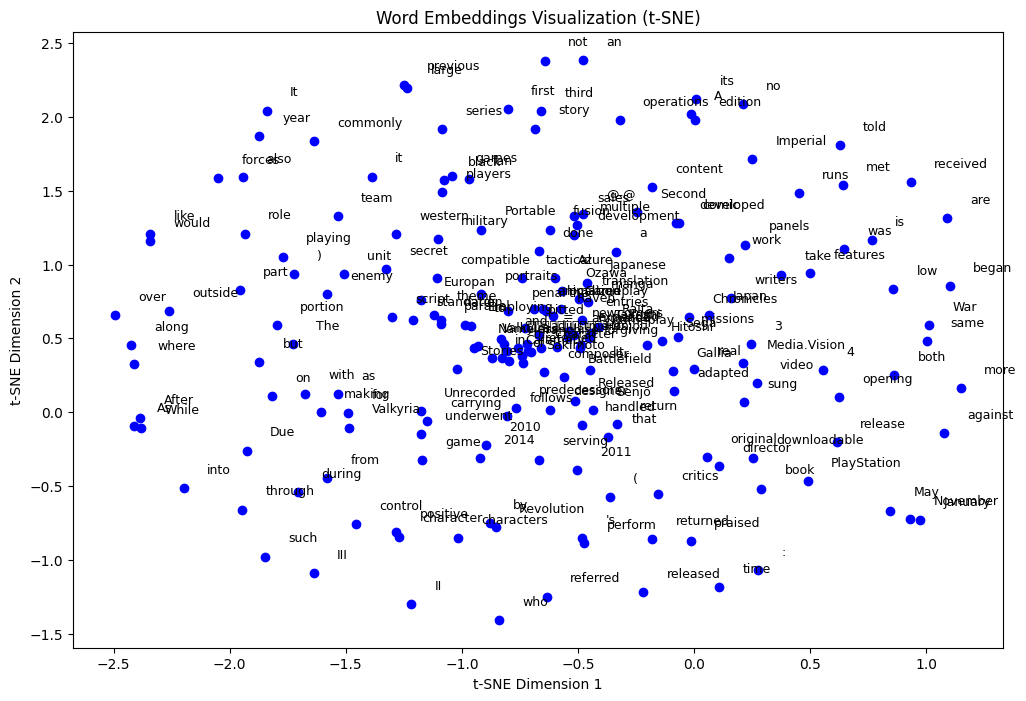

In [14]:
# Step 8.2: Visualize embeddings with t-SNE
def visualize_embeddings(embeddings, words, num_words=200):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings[:num_words])  # Reduce dimensionality

    # Plot the embeddings
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(words[:num_words]):
        x, y = reduced_embeddings[i]
        plt.scatter(x, y, marker='o', color='blue')
        plt.text(x + 0.1, y + 0.1, label, fontsize=9)
    plt.title("Word Embeddings Visualization (t-SNE)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

visualize_embeddings(embeddings, words)

## Step 7: Word Similarity Task

In [15]:
import numpy as np

# Step 1: Define a function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Step 2: Find similar words
def find_similar_words(word, vocabulary, embeddings, top_n=5):
    if word not in vocabulary:
        print(f"Word '{word}' not in vocabulary.")
        return []

    word_idx = vocabulary[word]
    word_vec = embeddings[word_idx]
    
    # Compute similarity for all words
    similarities = []
    for other_word, other_idx in vocabulary.items():
        if other_word == word:
            continue
        other_vec = embeddings[other_idx]
        similarity = cosine_similarity(word_vec, other_vec)
        similarities.append((other_word, similarity))
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Test word similarity
word = "king"  # Change to a word in your vocabulary
similar_words = find_similar_words(word, vocabulary, embeddings)
print(f"Words similar to '{word}':")
for similar_word, similarity in similar_words:
    print(f"{similar_word}: {similarity:.4f}")

Words similar to 'king':
1303rd: 0.2806
Enraged: 0.2781
Zankou: 0.2644
daughter: 0.2643
Tripletail: 0.2589


# Step 9: Word Analogy Task

In [16]:
# Step 1: Perform word analogy
def word_analogy(word_a, word_b, word_c, vocabulary, embeddings):
    if word_a not in vocabulary or word_b not in vocabulary or word_c not in vocabulary:
        print("One or more words not in vocabulary.")
        return None

    # Get vectors for the three words
    vec_a = embeddings[vocabulary[word_a]]
    vec_b = embeddings[vocabulary[word_b]]
    vec_c = embeddings[vocabulary[word_c]]

    # Compute the analogy vector: vec_d = vec_b - vec_a + vec_c
    analogy_vec = vec_b - vec_a + vec_c

    # Find the closest word to vec_d
    best_word = None
    best_similarity = -float('inf')
    for word, idx in vocabulary.items():
        if word in [word_a, word_b, word_c]:
            continue
        vec = embeddings[idx]
        similarity = cosine_similarity(analogy_vec, vec)
        if similarity > best_similarity:
            best_similarity = similarity
            best_word = word

    return best_word

# Test word analogy
word_a, word_b, word_c = "king", "man", "woman"  # Example analogy
result = word_analogy(word_a, word_b, word_c, vocabulary, embeddings)
print(f"'{word_a}' - '{word_b}' + '{word_c}' ≈ '{result}'")

'king' - 'man' + 'woman' ≈ 'Chestnuts'
